## Image Captioning
### Steps
- Data Collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing of Images
- Data Preprocessing of Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

## Flikr8K dataset
- 8k total images
- 6k for training
- 1k for validation and 1k for testing
- each image has 5 captions

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import json
from time import time
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 , preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout,Embedding, LSTM
from keras.layers.merge import add

In [2]:
plt.style.use("seaborn")

## Data Collection

### Read text Captions

In [3]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [4]:
captions = readTextFile("../input/flickr8k/captions.txt")

In [5]:
captions = captions.split("\n")[:-1]
len(captions)

40456

### Creating a dict to correspond image to its list of captions

In [6]:
first,second =captions[4].split('.jpg,')
print(first)
print(second)

1000268201_693b08cb0e
A little girl climbing the stairs to her playhouse .


In [7]:
descriptions ={}
for x in captions[1:]:
    first,second =x.split('.jpg,')
    img_name = first
    # if the image id is present or not 
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)
    
    

In [8]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
IMG_PATH = "../input/flickr8k/Images"

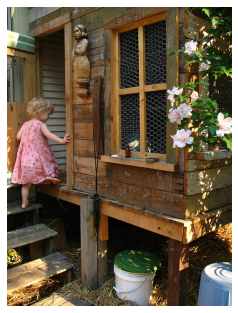

In [10]:
img = cv2.imread("../input/flickr8k/Images/1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()


## Data Cleaning
- don't remove stopwords : the model should know how to insert stopwords in a sentence
- don't perform stemming : for proper English
- remove non-alphabetical symbols : reduces vocab size

In [11]:
def cleanText(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [12]:
cleanText("A cat is sitting over the house #664")

'cat is sitting over the house'

In [13]:
# Lets clean all the captions 
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = cleanText(caption_list[i])

In [14]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

## Storing the modified captions in a text file

In [15]:
with open("descriptions_1.txt",'w') as f:
    f.write(str(descriptions))


## Vocabulary
- set of all unique words our model can predict
- model gives an output in the form of a vector
- we need to convert that vector into a specific word
- therefore, we need a vocab

In [16]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")    
descriptions = json.loads(json_acceptable_string)    

In [17]:
print(type(descriptions))

<class 'dict'>


In [18]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [19]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print(len(vocab))    

8424


In [20]:
# Total number of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Length of total words is %d"%(len(total_words)))    

Length of total words is 373803


### Filter words from the vocab according to a certain threshold

In [21]:
import collections 

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
#print(freq_cnt)
print(len(freq_cnt.keys())) # now this dict has the count of the 8424 words across all the captions

8424


In [22]:
# sort the dict accn to freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key = lambda x : x[1])

# Filter
threshold= 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [23]:
len(total_words) ## --> the final vocab size

1845

### Final Vocab Size : 1845 !!
- total words : 3,73,837
- unique words : 8,424
- filtered vocab : 1,845

## Prepare Train/Test Data

In [24]:
train_file_data = readTextFile("../input/flickr8k-text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("../input/flickr8k-text/Flickr_8k.testImages.txt")

In [25]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [26]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

### Prepare the descriptions for the training data
- also add </s/> and </e/> start and end token to our training data

In [27]:
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap +  " endseq"
        train_descriptions[img_id].append(cap_to_append)
    

In [28]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Transfer Learning
- Images --> Features
- Text --> Features

## Step -1 Image Feature Extraction

- ResNet50 Model
- It has skip connections and branching
- That is why, there is separate column for "Connected to"
- Skip Connections helps in tackling with Vanishing Gradients

In [29]:
# ResNet is not a sequential model --> it has skip connections which also helps in dealing with the problem of vanishing gradients
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

2022-02-12 21:13:19.738277: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [30]:
model.layers[-2] #-->the GAP layer 

In [31]:
# now we are creating a model where input part is as the above model but at the end of it we are using a GAP layer to get out output layer
model_new = Model(model.input,model.layers[-2].output)

### Extraction of features from images
- Image is preprocessed
- Passed to ResNet-50 Conv Base
- Receives a (m X 2048) tensor [ m : number of examples ]
- Store these feature vectors

In [32]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    #Normalisation
    img = preprocess_input(img)
    return img

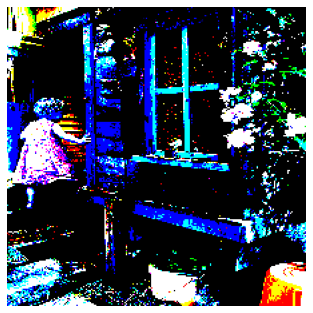

In [33]:
#sample
img = preprocess_img("../input/flickr8k/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [34]:
# encoding an image
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
#     print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [35]:
encode_image(IMG_PATH+"/"+"1000268201_693b08cb0e.jpg")

2022-02-12 21:13:23.821364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([0.06535928, 0.1678255 , 0.3251769 , ..., 0.05107141, 0.32821223,
       1.0043367 ], dtype=float32)

In [36]:
start = time()
#Encoding all images
encoding_train ={}
# image_id --> feature_vector extracted from ResNet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    
    if(ix%100==0):
        print("Encoding in Progress Time step %d "%ix)

end = time()        
print("Total Time Taken :",end-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

## Storing all the features to the disk
- We will use PICKLE
- RAM <=> DISK
- for storing data in disk : dump
- for loading data in RAM : load

In [37]:
import pickle

In [38]:
with open("encoded_train_feature.pkl","wb") as f:
    pickle.dump(encoding_train,f)

## Doing the same for test images

In [39]:
start = time()
#Encoding all images
encoding_test ={}
# image_id --> feature_vector extracted from ResNet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id]=encode_image(img_path)
    
    if(ix%100==0):
        print("Test Encoding in Progress Time step %d "%ix)

end = time()        
print("Total Time Taken(test) :",end-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 145.50758481025696


In [40]:
with open("encoded_test_feature.pkl","wb") as f:
    pickle.dump(encoding_test,f)

## Step 2- Data Preprocessing -- Captions

In [41]:
#Vocab
len(total_words)

1845

In [42]:
word_to_idx={}
idx_to_word={}
for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1]=word
    

In [43]:
# Now adding two special words the start and end sequence
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846
idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

vocab_size = len(word_to_idx)+1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [44]:
train_descriptions["2513260012_03d33305cf"][0].split()

['startseq',
 'black',
 'dog',
 'is',
 'running',
 'after',
 'white',
 'dog',
 'in',
 'the',
 'snow',
 'endseq']

In [45]:
# to get the max possible length of a caption
maxlen = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        maxlen = max(maxlen,len(cap.split()))
        
print(maxlen)

35


## Data Loader(Generator)

In [46]:
def data_generator(train_descriptions,encoding_train,word_to_idx,maxlen,batch_size):
    X1,X2,y = [],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=maxlen,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n=0 
                    
                    
                    
                

## Word Embeddings

In [47]:
f = open("../input/glove6b50dtxt/glove.6B.50d.txt",encoding='utf8')

In [48]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
    
f.close()

In [49]:
def get_embedding_matrix():
    emb_dim=50
    matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix

In [50]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


## Model Architecture

In [51]:
# for images
input_imgs_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_imgs_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [52]:
#Captions as input
input_captions = Input(shape=(maxlen,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
#inp_cap3 --> whole caption generated till now

In [53]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs= [input_imgs_features,input_captions],outputs=outputs)

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [55]:
#Pre Initialise the Embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [56]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

## Training of model

In [57]:
epochs =30
batch_size=3
steps = len(train_descriptions)//batch_size

In [58]:
import os
os.mkdir("model_weights")

In [59]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,maxlen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights/model_'+str(i)+'.h5')

In [60]:
# train()
model = load_model("../input/best-model/model_29.h5")

## Predictions

In [61]:
maxlen

35

In [62]:
def predict_caption(photo):
    
    # We will feed 2 things to the model
    # 1. Feed the image vector (2048,)
    # 2. Provide the start sequence "startseq" (<s>)
    
    inp_text = "startseq"
    
    for i in range(maxlen):
        
        sequence = [word_to_idx[w] for w in inp_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=maxlen, padding='post')
        
        ypred = model.predict([photo,sequence])
        
        # Greedy Sampling : Word with max probability always
        ypred = ypred.argmax()
        
        # retreiving the word
        word = idx_to_word[ypred]
        
        # adding it to the sequence
        inp_text += (' ' + word)
        
        # If <e>/end sequence is encountered
        if word == "endseq":
            break
            
    # removing <s> and <e>
    final_caption = inp_text.split(' ')[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

# **Testing**

woman in black shirt and black boots is walking


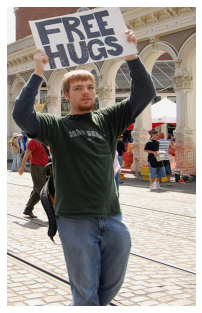

man in white shirt and white shirt playing tennis


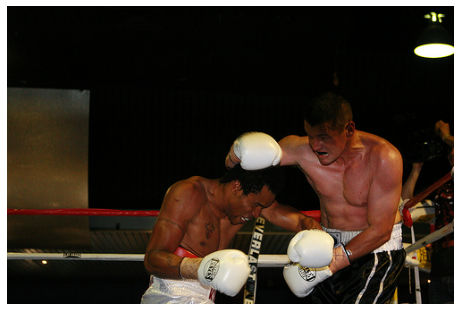

three men are riding three dogs on the dirt


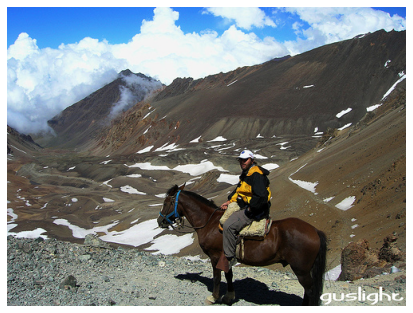

child in red shirt is laying on the grass


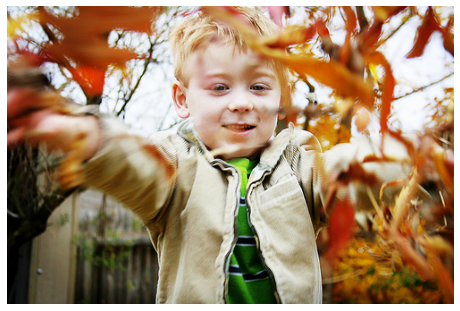

man in black shirt and jeans sits in chair of chair of man in jeans


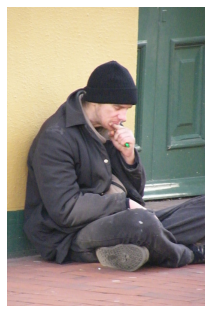

child in red shirt is walking through the grass


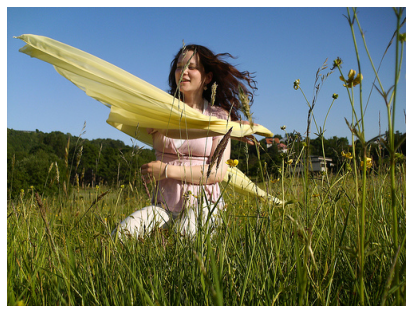

bicyclist is doing trick on ramp


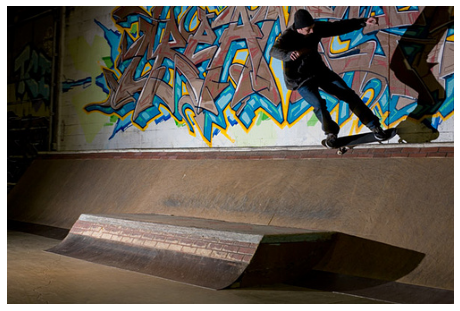

man with an orange shirt and black helmet is holding up peace sign


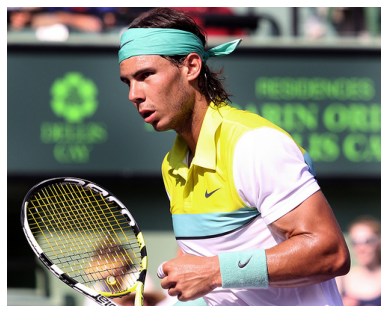

little girl in pink shirt is playing in fountain


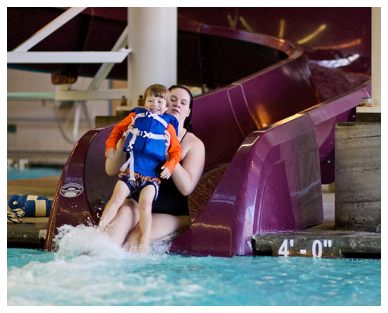

man in red shirt is rock climbing


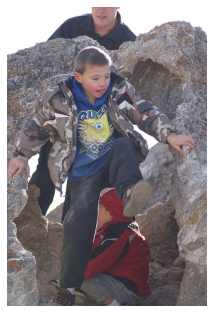

small boy in pool


brown dog is rolling on its back


man in stripes shirt and black shorts is walking on the grass


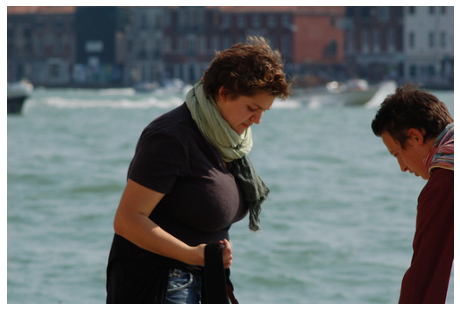

boy in shorts and shorts is running


little girl in pink shirt is riding red plastic toy


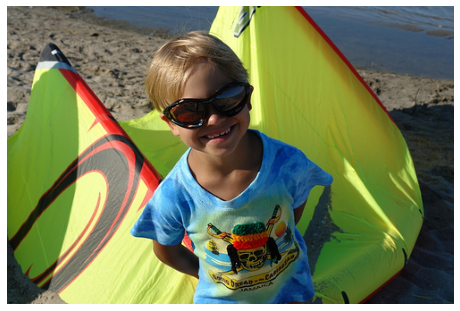

In [63]:
# Pick some random images and see results
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
#     print(img_name)
    
    i = plt.imread(IMG_PATH+"/"+img_name+".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    
    plt.show()
    